In [44]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import io
%matplotlib inline

In [45]:
#From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

In [46]:
#load the data
train = pd.read_csv("train_raw.csv", parse_dates=['timestamp'],index_col='id') # index_col='id' if remove bad address, remove id
test = pd.read_csv("test_raw.csv", parse_dates=['timestamp'],index_col='id')
df_macro = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

In [47]:
#fix bad addresses
fx = pd.read_excel('BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')

train.update(fx)
test.update(fx)

print('Fix in train: ', train.index.intersection(fx.index).shape[0])
print('Fix in test : ', test.index.intersection(fx.index).shape[0])

train.head()

('Fix in train: ', 550)
('Fix in test : ', 149)


,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452


1.0 44.0
1 41


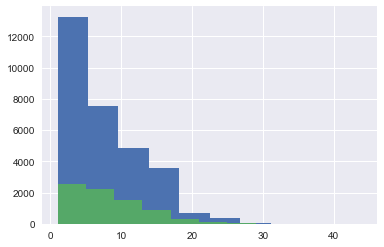

In [48]:
#clean Jules
# Build Year
train.loc[30153,'build_year']=2015
train.loc[30278,'build_year']=np.NaN
train.loc[13995,'build_year']=2014
train.loc[26335,'build_year']=1961
train.loc[14161,'build_year']=1960
train.loc[10092,'build_year']=2009
train.loc[15223,'build_year']=1965

train.loc[train['build_year'].isin([0,1,3]),'build_year'] = np.NaN

test.loc[33469,'build_year']=2015
test.loc[test['build_year'].isin([0,1,2]),'build_year'] = np.NaN

# Max_floor
train.loc[20725,'max_floor']=9
train.loc[21737,'max_floor']=17 #Average of location (all between 14 and 25)
train.loc[21855,'max_floor']=25 #All at this location have 25
train.loc[25943,'max_floor']= np.NaN

train.loc[train['max_floor']==0,'max_floor'] = np.NaN
train.loc[train['max_floor']<train['floor'],'max_floor'] = np.NaN

test.loc[test['max_floor']==0,'max_floor'] = np.NaN
test.loc[test['max_floor']<test['floor'],'max_floor'] = np.NaN

# Floor
train.loc[train['floor']==0,'floor'] = np.NaN
train.loc[23587,'floor'] = np.NaN

train['floor'].hist()
test['floor'].hist()
print np.min(train['floor']),np.max(train['floor'])
print np.min(test['floor']),np.max(test['floor'])

# Full and life sq (Run only once!)

train.loc[[1030,27796,3599,22788,129,18344,23718,1310],['full_sq','life_sq']] = train.loc[[1030,27796,3599,22788,129,18344,23718,1310],['full_sq','life_sq']] /10.0

train.loc[[2012,1189,11335,22415,24299,26267,26366,1825],'full_sq'] = train.loc[[2012,1189,11335,22415,24299,26267,26366,1825],'life_sq']
train.loc[6115,'full_sq'] = np.NaN

train.loc[((train['full_sq']==1) & (train['life_sq']==1) & (train['floor']==1)) | ((train['full_sq']==0) & (train['life_sq']==0) & (train['floor']==0)),['full_sq','life_sq','floor','max_floor','num_room','kitch_sq','state']] = np.NaN
train.loc[((train['full_sq']==0) | (train['full_sq']==1)) & train['life_sq']>5, 'full_sq'] = train.loc[((train['full_sq']==0) | (train['full_sq']==1)) & train['life_sq']>5, 'life_sq']

train.loc[(train['life_sq']>1) & (train['full_sq']>100*train['life_sq']),'full_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']>100*train['life_sq']),'full_sq']/100.0
train.loc[(train['life_sq']>1) & (train['full_sq']>10*train['life_sq']),'full_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']>10*train['life_sq']),'full_sq']/10.0

train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.05),'life_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.5),'life_sq']/100.0
train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.5),'life_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.5),'life_sq']/10.0

train.loc[(train['full_sq']==0) | (train['full_sq']==1),'full_sq'] = np.NaN
train.loc[(train['life_sq']==0) | (train['life_sq']==1),'life_sq'] = np.NaN



test.loc[[30938,35857],'full_sq'] = test.loc[[30938,35857],'life_sq']
test.loc[36824, ['full_sq','life_sq']] = np.NaN
test.loc[[32501,33278],'life_sq'] = np.NaN

test.loc[(test['life_sq']>1) & (test['full_sq']/test['life_sq']<0.5),'life_sq'] = test.loc[(test['life_sq']>1) & (test['full_sq']/test['life_sq']<0.5),'life_sq']/10.0

test.loc[(test['life_sq']==0 ) | (test['life_sq']==1 ),'life_sq'] = np.NaN

# Kitchen (Only run once!)

train.loc[[10371,21418,13120,28737],'build_year'] = train.loc[[10371,21418,13120,28737],'kitch_sq'].copy()
train.loc[[10371,21418,13120,28737],'kitch_sq'] = np.NaN

train.loc[(train['kitch_sq']==0) | (train['kitch_sq']==1),'kitch_sq'] = np.NaN
train.loc[(train['kitch_sq'] >= train['full_sq']) | (train['kitch_sq']>= train['life_sq']),'kitch_sq'] = np.NaN

test.loc[[31381,36811],'kitch_sq'] = np.NaN
test.loc[test['kitch_sq']==test['full_sq'],'kitch_sq'] = np.NaN
test.loc[[37733,37503],'kitch_sq'] = np.NaN

test.loc[[32505,34333,36970],'kitch_sq'] = test.loc[[32505,34333,36970],'kitch_sq']/10.0
test.loc[[31014,32266],['kitch_sq','life_sq']] = test.loc[[31014,32266],['life_sq','kitch_sq']]
test.loc[(test['kitch_sq'] >= test['full_sq']) | (test['kitch_sq']>= test['life_sq']),'kitch_sq'] = np.NaN
test.loc[(test['kitch_sq']==0) | (test['kitch_sq']==1),'kitch_sq'] = np.NaN

# Room
train.loc[train['num_room']==0, 'num_room'] = np.NaN
train.loc[train['num_room'] >= 10, 'num_room'] = np.NaN
train.loc[[19393,25350,26002,17431,25284,12201,14592,11020,25654],'num_room'] = np.NaN

test.loc[31301, 'num_room'] = 3 #kitch_sq
test.loc[[33648,37787,31903],'num_room'] = np.NaN

# State
train.loc[10092,'state'] = 3

In [50]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [55]:
test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9.0,1,1998.0,1.0,8.9,...,8.0,0.0,0.0,0.0,1.0,10.0,1.0,0.0,14.0,1.0
1,30475,2015-07-01,79.2,NaN,8,17.0,1,NaN,3.0,NaN,...,4.0,1.0,1.0,0.0,2.0,11.0,0.0,1.0,12.0,1.0
2,30476,2015-07-01,40.5,25.1,3,5.0,2,1960.0,2.0,4.8,...,42.0,11.0,4.0,0.0,10.0,21.0,0.0,10.0,71.0,11.0
3,30477,2015-07-01,62.8,36.0,17,17.0,1,2016.0,2.0,NaN,...,1.0,1.0,2.0,0.0,0.0,10.0,0.0,0.0,2.0,0.0
4,30478,2015-07-01,40.0,40.0,17,17.0,1,NaN,1.0,NaN,...,5.0,1.0,1.0,0.0,2.0,12.0,0.0,1.0,11.0,1.0


In [56]:
#ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(train['price_doc'].values)
id_test = test['id']

train.drop(['id','price_doc'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

#Build df_all = (df_train+df_test).join(df_macro)
num_train = len(train)
df_all = pd.concat([train, test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
print(df_all.shape)

# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

#Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)

(38133, 303)


In [57]:
#Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [58]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(38133, 302)
('X_train_all shape is', (30471, 302))
('X_train shape is', (24377, 302))
('y_train shape is', (24377,))
('X_val shape is', (6094, 302))
('y_val shape is', (6094,))
('X_test shape is', (7662, 302))


In [59]:
X_train_all[np.isnan(X_train_all)]=-999999
ylog_train_all[np.isnan(ylog_train_all)]=-999999
X_train[np.isnan(X_train)]=-999999
ylog_train[np.isnan(ylog_train)]=-999999
X_val[np.isnan(X_val)]=-999999
ylog_val[np.isnan(ylog_val)]=-999999
X_test[np.isnan(X_test)]=-999999

In [60]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all,missing=-999999)
dtrain = xgb.DMatrix(X_train, ylog_train,missing=-999999)
dval = xgb.DMatrix(X_val, ylog_val,missing=-999999)
dtest = xgb.DMatrix(X_test,missing=-999999)

In [61]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

Will train until val error hasn't decreased in 20 rounds.
[0]	val-rmse:14.476494
[1]	val-rmse:13.759711
[2]	val-rmse:13.080470
[3]	val-rmse:12.432445
[4]	val-rmse:11.818080
[5]	val-rmse:11.234531
[6]	val-rmse:10.679843
[7]	val-rmse:10.151852
[8]	val-rmse:9.650874
[9]	val-rmse:9.175421
[10]	val-rmse:8.723789
[11]	val-rmse:8.294916
[12]	val-rmse:7.887187
[13]	val-rmse:7.499231
[14]	val-rmse:7.131306
[15]	val-rmse:6.781193
[16]	val-rmse:6.449465
[17]	val-rmse:6.134683
[18]	val-rmse:5.833958
[19]	val-rmse:5.549026
[20]	val-rmse:5.279372
[21]	val-rmse:5.021502
[22]	val-rmse:4.777956
[23]	val-rmse:4.545819
[24]	val-rmse:4.325052
[25]	val-rmse:4.116240
[26]	val-rmse:3.917675
[27]	val-rmse:3.728212
[28]	val-rmse:3.549674
[29]	val-rmse:3.379572
[30]	val-rmse:3.219608
[31]	val-rmse:3.066319
[32]	val-rmse:2.921082
[33]	val-rmse:2.784060
[34]	val-rmse:2.653007
[35]	val-rmse:2.528476
[36]	val-rmse:2.410493
[37]	val-rmse:2.298749
[38]	val-rmse:2.192835
[39]	val-rmse:2.092099
[40]	val-rmse:1.996917
[

In [62]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

In [63]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

In [64]:
df_sub.to_csv('Nofillna_Julescleaning_0.419111.csv', index=False)